In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from enum import Enum
from typing import Optional, Tuple, List
from multiprocessing import Pool
import os
import shutil

from PIL import Image
import matplotlib.pyplot as plt # Image display
from medmnist import OrganAMNIST # Dataset
import numpy as np
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.ndimage import rotate
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, iradon_sart, rescale, resize

import torch
from torchvision import transforms
from numpy.random import RandomState
from torchvision.utils import save_image
from torchvision.transforms import ToTensor
import torch.utils.data as data
from torchvision.transforms.functional import pil_to_tensor

from tqdm import tqdm # Progress bar

# Custom code from this project
from src.preprocess.ct.corruption import SinogramCorruptor
from src.preprocess.ct.padder import Padder, SymmetricPadder, ShiftPadder
from src.preprocess.ct.projector import Projector, KernelType
from src.visualize.imshow_gray import ImShowGray

In [3]:
MEDMNIST_LOCAL_DIR = "/data/.medmnist"
OUTPUTS_DIR = "/data/ring_v2_preprocessed"
datasets = {}
splits = ["train", "val", "test"]
for split in splits:
  if os.path.exists(MEDMNIST_LOCAL_DIR):
    datasets[split] = OrganAMNIST(split=split, size=224, root=MEDMNIST_LOCAL_DIR)
  else:
    datasets[split] = OrganAMNIST(split=split, size=224, download=True)
    shutil.move("/root/.medmnist", MEDMNIST_LOCAL_DIR)
  print(len(datasets[split]), f"images in the {split} dataset")

34561 images in the train dataset
6491 images in the val dataset
17778 images in the test dataset


In [4]:
# Distortion Classes

class RingArtifactUniformlyRandom:
  """
  Simulate CT ring artifacts in an image.
  No prior knowledge can be assumed about the world coordinates of the anatomy.
  For each detector, apply a gain error of up to `gain_error_range`.
  The ring may be shifted by an integer number of pixels, up to plus or minus `shift_range` many pixels in each direction.
  """
  def __init__(self, shift_range: int, gain_error_range: Tuple[float, float]):
    """
    Args:
      shift_range: Maximum number of pixels by which to shift the ring.
      gain_error_range: Maximum negative & positive gain error to apply to the ring. A value of 0.03 is treated as 3% gain error, for example.
    """
    self.shift_range = shift_range
    self.gain_error_range = gain_error_range

  def __call__(self, img: Image.Image) -> np.ndarray:
    """
    Note that this function generates random shift and gain error.
    """
    # Min-max normalize, assuming all images can be in range 0-255.
    # This helps keep the input to the Radon transform in a comparable
    # range to the output from the inverse Radon transform.
    img = np.asarray(img).astype(np.float32) / 255.0

    # Draw random shift error.
    shift_down = np.random.randint(-self.shift_range, self.shift_range+1)
    shift_right = np.random.randint(-self.shift_range, self.shift_range+1)

    # Pad the image so that when it is rotated during forward projection, no data is lost.
    padder = ShiftPadder(shift_down=shift_down, shift_right=shift_right, arr_shape=img.shape, circumscribe=True)
    img_pad = padder.pad(img)

    # _ = ImShowGray.imshow(img_pad, title="Padded Image", title_stats=True)

    num_projections = max(img_pad.shape)*2
    # Need 360 degree scanning to produce the full ring artifact instead of just half a ring.
    theta = np.linspace(0., 360., num=num_projections, endpoint=False)

    sinogram = radon(img_pad, theta=theta)

    # Assume all detectors have a gain error.
    faulty_detectors = list(range(sinogram.shape[0]))

    # Draw random gain errors.
    GAIN_MIN = 1.00 + self.gain_error_range[0]
    # Assume the detector will not get more sensitive.
    GAIN_MAX = 1.00 + self.gain_error_range[1]
    
    faulty_detector_gains = ((np.random.random(sinogram.shape[0]) * (GAIN_MAX-GAIN_MIN)) + GAIN_MIN).tolist()

    corruptor = SinogramCorruptor()
    sinogram_corrupt = corruptor.create_multiplicative_ring_artifact(sinogram, detectors=faulty_detectors, factors=faulty_detector_gains)

    img_recon_pad = iradon(sinogram, theta=theta, filter_name='ramp')
    img_recon_pad_corrupt = iradon(sinogram_corrupt, theta=theta, filter_name='ramp')

    img_recon = padder.unpad(img_recon_pad)
    img_recon_corrupt = padder.unpad(img_recon_pad_corrupt)

    # To keep the corruption without having the reconstruction error,
    # take difference between reconstructed image with and without corruption
    # to derive an image of just the corruption.
    # Then, add this corruption back to the original image.
    corruption = img_recon_corrupt - img_recon
    img_corrupt = img + corruption

    # _,_ = ImShowGray.imshow_diff(img_recon, img, titles=("Reconstructed","Original"), title_stats=True, title_window=True, window=[0, 1])
    # _ = ImShowGray.imshow(sinogram, title="Sinogram", title_stats=True)

    # _,_ = ImShowGray.imshow_diff(img_recon_corrupt, img, titles=("Distorted Recon.","Original"), title_stats=True, title_window=True, window=[0, 1])
    # _ = ImShowGray.imshow(sinogram_corrupt, title="Distorted Sinogram", title_stats=True)

    # _,_ = ImShowGray.imshow_diff(img_corrupt, img, titles=("Distorted","Original"), title_stats=True, title_window=True, window=[0, 1])

    return np.asarray(img_corrupt)

In [5]:
# Visualization

def show_distortion_comparison_ring(dataset, transforms_dict, indices):
  """
  Show the original image and its distortions side by side.

  Parameters:
  - dataset: OrganMNIST dataset (PIL images, transform=None)
  - transforms_dict: dict of {name: transform}
  - indices: list of dataset indices to save
  """
  num_imgs = len(indices)
  num_transforms = len(transforms_dict)

  plt.figure(figsize=(4 * (num_transforms + 1), 3 * num_imgs))

  for row, idx in enumerate(indices):
    raw_img, label = dataset[idx]
    raw_np = np.asarray(raw_img)

    # Column 0: Original
    plt.subplot(num_imgs, num_transforms + 1, row * (num_transforms + 1) + 1)
    plt.imshow(raw_np, cmap='gray')
    plt.title(f"Original\nImage: {idx}\nLabel: {label}")
    plt.axis('off')

    # Distorted columns
    for col, (name, transform) in enumerate(transforms_dict.items(), start=1):
      distorted_np = transform(raw_img)
      plt.subplot(num_imgs, num_transforms + 1, row * (num_transforms + 1) + col + 1)
      plt.imshow(distorted_np, cmap='gray')
      plt.title(f"{name}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [6]:
def save_distorted_subset_to_npz_ring(dataset, transforms_dict, indices, output_root, filename="subset_all_in_one.npz"):
  """
  Save a subset of images (original + distortions) into one .npz file.

  Parameters:
  - dataset: OrganMNIST dataset (PIL images, transform=None)
  - split_name: "train", "val", or "test"
  - transforms_dict: dict of {name: transform}
  - indices: list of dataset indices to save
  - output_root: folder to save the single .npz file
  """
  os.makedirs(output_root, exist_ok=True)
  save_path = os.path.join(output_root, filename)

  original_list = []
  label_list = []
  distortion_lists = {name.replace(" ", "_").replace("°", "deg"): [] for name in transforms_dict}

  with open(f"{filename}.log", "w") as log_file:
    for idx in tqdm(indices, file=log_file):
      # Modified.
      raw_img, label = dataset[idx]
      orig_np = np.asarray(raw_img).astype(np.float32) / 255.0
      original_list.append(orig_np)
      label_list.append(label)

      for name, transform in transforms_dict.items():
        key = name.replace(" ", "_").replace("°", "deg")
        transformed_np = transform(raw_img)
        distortion_lists[key].append(transformed_np)

  # Build final save dict
  save_dict = {
    "original": np.stack(original_list),
    "label": np.array(label_list)
  }
  for key, value_list in distortion_lists.items():
    save_dict[key] = np.stack(value_list)

  np.savez_compressed(save_path, **save_dict)
  print(f"\nSaved {len(indices)} distorted images to single file: {save_path}")

In [7]:
np.random.seed(0)

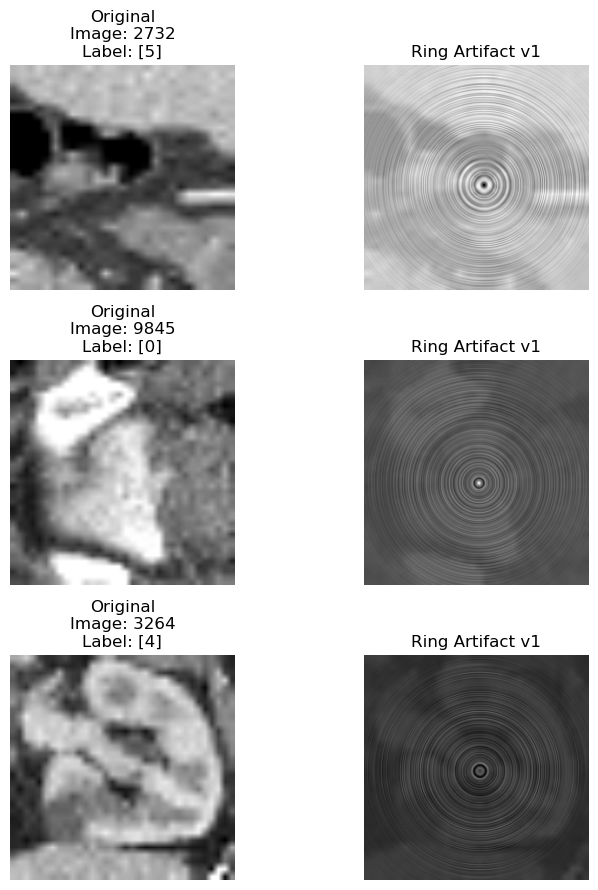

In [8]:
# Load PIL image version (no transform)
distortions = {
  "Ring Artifact v1": RingArtifactUniformlyRandom(shift_range = 10, gain_error_range = (-0.1, 0.1)),
}

# Random indices
train_subset_indices = np.random.choice(10000, 3)
# test_subset_indices = np.random.choice(10000, 4)
# val_subset_indices = np.random.choice(10000, 4)

# Display the images
show_distortion_comparison_ring(datasets["train"], distortions, indices=train_subset_indices)

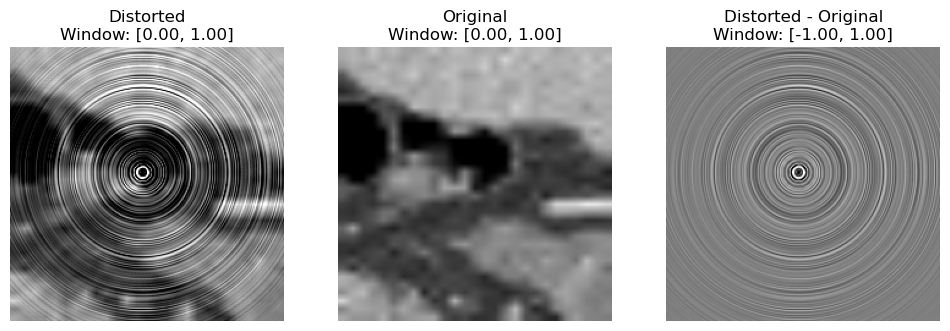

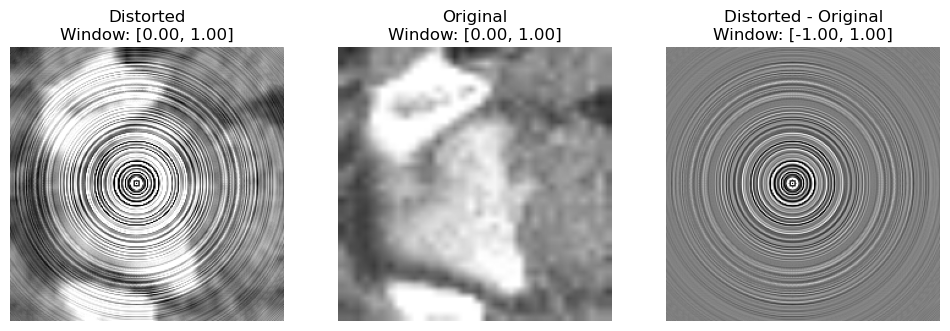

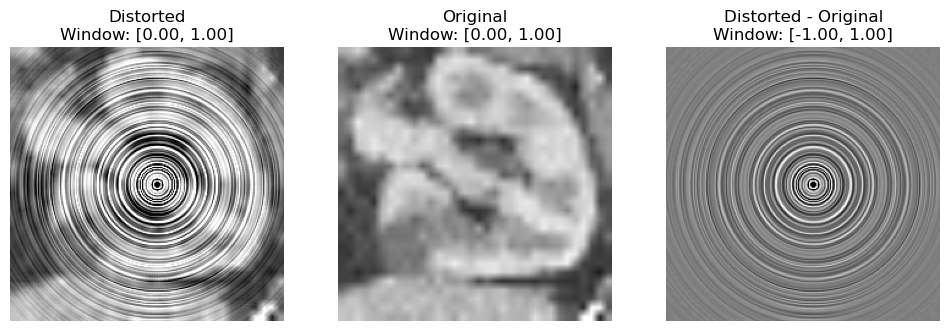

In [17]:
# Show difference image as well
for i in train_subset_indices:
  img = datasets["train"][i][0]

  distorter = RingArtifactUniformlyRandom(
    # Choosing a fairly small shift to emulate relative displacement of patient on table.
    # Displacement of anatomy relative to patient axis is not in scope.
    shift_range = 10,
    # Individual pixel gain error is "typically within a few percent", according to:
    # Blaj, Gabriel. "Dead-time correction for spectroscopic photon-counting pixel detectors." Synchrotron Radiation 26.5 (2019): 1621-1630.
    gain_error_range = (-0.1, 0.1),
  )

  img_corrupt = distorter(img)

  img_normalized = np.asarray(img).astype(np.float32) / 255.0
  fig,ax = ImShowGray.imshow_diff(img_corrupt, img_normalized, titles=("Distorted","Original"), title_stats=False, title_window=True, window=[0, 1], diff_window=[-1, 1], include_abs_diff=False)
  plt.savefig(f"{i}.png")

## Let's split up the work starting here

In [ ]:
jobs = [
  {
    "seed": 1,
    "split": "train",
    "start": 0,
    "stop": 5000,
    "filename": "train_subset_first_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 2,
    "split": "train",
    "start": 5000,
    "stop": 10000,
    "filename": "train_subset_second_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 3,
    "split": "train",
    "start": 10000,
    "stop": 15000,
    "filename": "train_subset_third_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 4,
    "split": "train",
    "start": 15000,
    "stop": 20000,
    "filename": "train_subset_fourth_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 5,
    "split": "train",
    "start": 20000,
    "stop": 25000,
    "filename": "train_subset_fifth_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 6,
    "split": "train",
    "start": 25000,
    "stop": 30000,
    "filename": "train_subset_sixth_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 7,
    "split": "train",
    "start": 30000,
    "stop": 34561,
    "filename": "train_subset_last_4561_RingArtifactv1_images.npz"
  },
  {
    "seed": 8,
    "split": "val",
    "start": 0,
    "stop": 5000,
    "filename": "val_subset_first_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 9,
    "split": "val",
    "start": 5000,
    "stop": 6491,
    "filename": "val_subset_last_1491_RingArtifactv1_images.npz"
  },
  {
    "seed": 10,
    "split": "test",
    "start": 0,
    "stop": 5000,
    "filename": "test_subset_first_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 11,
    "split": "test",
    "start": 5000,
    "stop": 10000,
    "filename": "test_subset_second_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 12,
    "split": "test",
    "start": 10000,
    "stop": 15000,
    "filename": "test_subset_third_5000_RingArtifactv1_images.npz"
  },
  {
    "seed": 13,
    "split": "test",
    "start": 15000,
    "stop": 17778,
    "filename": "test_subset_last_2778_RingArtifactv1_images.npz"
  },
]

def wrap_save_distorted_subset_to_npz_ring(job):
  np.random.seed(job["seed"])
  save_distorted_subset_to_npz_ring(
    dataset=datasets[job["split"]],
    transforms_dict=distortions,
    indices=np.arange(job["start"],job["stop"]),
    output_root=os.path.join(OUTPUTS_DIR, "RingArtifactv1_npz"),
    filename=job["filename"]
  )


In [ ]:
# Now run the jobs defined above.

FIRST_JOB_TO_RUN=0
NUM_JOBS_TO_RUN=len(jobs)
MAX_NUM_PROCESSES=3

assert NUM_JOBS_TO_RUN-FIRST_JOB_TO_RUN <= len(jobs), "Don't need to run more jobs than the total number of jobs that exist"

batch_start_indices = range(FIRST_JOB_TO_RUN, FIRST_JOB_TO_RUN+NUM_JOBS_TO_RUN, MAX_NUM_PROCESSES)
nums_processes = [min(MAX_NUM_PROCESSES, NUM_JOBS_TO_RUN-starting_job) for starting_job in batch_start_indices]

print(f"In the following sequential order, I will run the {NUM_JOBS_TO_RUN} jobs using parallel processing:")
for batch_start_index, num_processes in zip(batch_start_indices, nums_processes):
    print(f"Run {num_processes} jobs in parallel, starting at index {batch_start_index}")
print(f"\nExecuting now...")
for batch_start_index, num_processes in zip(batch_start_indices, nums_processes):
    print(f"Running jobs {batch_start_index} through {batch_start_index+num_processes-1}, inclusive")
    with Pool(processes=num_processes) as pool:
        pool.map(wrap_save_distorted_subset_to_npz_ring, jobs[batch_start_index:(batch_start_index+num_processes)])

In [ ]:
npz_path = os.path.join(OUTPUTS_DIR, "RingArtifactv1_npz/train_subset_first_5000_RingArtifactv1_images.npz")
distorted_images = np.load(npz_path)

print("Available keys in the file:", distorted_images.files)

# Inspect shapes and types
for key in distorted_images.files:
    print(f"{key}: shape={distorted_images[key].shape}, dtype={distorted_images[key].dtype}")

In [ ]:
def show_npz_image_set(npz_path, index=0):
    """
    Display all images (original + distortions) at a given index from a .npz file.

    Parameters:
    - npz_path: Path to the .npz file
    - index: Index of the image to display
    """
    data = np.load(npz_path)
    keys = [k for k in data.files if k != "label"]
    num_images = len(keys)

    plt.figure(figsize=(3 * num_images, 3))
    for i, key in enumerate(keys):
        img = data[key][index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(key)
        plt.axis('off')

    label = data["label"][index].item() if "label" in data else "N/A"
    plt.suptitle(f"Label: {label}")
    plt.tight_layout()
    plt.show()

    _,_ = ImShowGray.imshow_diff(data["Ring_Artifact_v1"][index], data["original"][index], titles=("Distorted","Original"), title_stats=True, title_window=True, window=[0, 1])